# MobileNeV2 trained on both cytopix and imagestream tryign to predict imagestream data

2024-08-20


In [7]:
from pathlib import Path

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rc("font", size=14)
plt.rc("axes", labelsize=14, titlesize=14)
plt.rc("legend", fontsize=14)
plt.rc("xtick", labelsize=10)
plt.rc("ytick", labelsize=10)

In [2]:
import tensorflow as tf
import keras

print(tf.__version__)
keras.backend.clear_session()

tf.random.set_seed(42)

2024-08-20 11:19:20.095492: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-20 11:19:20.111794: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-20 11:19:20.133657: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-20 11:19:20.133684: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-20 11:19:20.148352: I tensorflow/core/platform/cpu_feature_gua

2.16.2


Defining custom functions

In [4]:
from sklearn.metrics import ConfusionMatrixDisplay


def get_confusion_matrix(y_test, y_pred, class_names):

    _, ax = plt.subplots(figsize=(8, 8))
    ConfusionMatrixDisplay.from_predictions(
        y_test,
        y_pred,
        ax=ax,
        xticks_rotation="vertical",
        colorbar=False,
        normalize="true",
        display_labels=class_names,
    )

    plt.rc("font", size=12)
    ax.set_title(f"Confusion Matrix")

Load data

In [9]:
path_in = Path.cwd().parent / "resources/imagestream"

In [12]:
from keras.layers import (
    Rescaling,
    RandomFlip,
    RandomRotation,
    RandomTranslation,
    RandomContrast,
    RandomBrightness,
)

AUTOTUNE = tf.data.AUTOTUNE
IMG_SIZE = (96, 96)
BATCH_SIZE = 24

train_ds, test_ds = keras.utils.image_dataset_from_directory(
    path_in,
    labels="inferred",
    label_mode="int",
    class_names=["discocyte", "granular", "holly_leaf", "sickle", "echinocyte"],
    color_mode="rgb",
    batch_size=None,
    image_size=IMG_SIZE,
    shuffle=True,
    seed=93,
    validation_split=0.2,
    subset="both",
    data_format="channels_last",
    verbose=True,
)

class_names = test_ds.class_names

rescale = tf.keras.Sequential([Rescaling(1.0 / 255)])
data_augmentation = tf.keras.Sequential(
    [
        RandomFlip("horizontal_and_vertical"),
        RandomRotation(0.2),
        RandomTranslation(0.2, 0.2),
        RandomContrast(0.2),
        RandomBrightness(0.2),
    ]
)


def prepare(ds, batch_size, initial_dist=None, target_dist=None, augment=False):

    ds = ds.map(lambda x, y: (rescale(x), y), num_parallel_calls=AUTOTUNE)

    if augment:

        # Correct imbalance in class distribution
        ds = ds.rejection_resample(
            class_func=lambda x, y: y,
            initial_dist=initial_dist,
            target_dist=target_dist,
            seed=93,
        )

        # Flatten rejection resampling outputs ((class_func_results, x), y)
        ds = ds.map(lambda _, data: data)

        # Add augmentation to images
        ds = ds.map(
            lambda x, y: (data_augmentation(x, training=True), y),
            num_parallel_calls=AUTOTUNE,
        )

    ds = ds.batch(batch_size, num_parallel_calls=AUTOTUNE)

    return ds.prefetch(buffer_size=AUTOTUNE)


test_ds = prepare(
    test_ds,
    batch_size=BATCH_SIZE,
)

for data, label in test_ds.take(1):
    print(f"Test data shape: {data.shape}")

Found 14674 files belonging to 5 classes.
Using 11740 files for training.
Using 2934 files for validation.
Test data shape: (24, 96, 96, 3)


2024-08-20 11:25:21.079011: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Initialise model and load weights

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    BatchNormalization,
    ReLU,
    GlobalAveragePooling2D,
)
from tensorflow.keras.regularizers import L2
from tensorflow.keras.applications import MobileNetV2


mobile_net = keras.applications.MobileNetV2(
    input_shape=(96, 96, 3),
    alpha=1.0,
    include_top=False,
    weights=None,
)

model = Sequential()

model.add(mobile_net)

model.add(GlobalAveragePooling2D())
model.add(Dense(5, activation="softmax"))

model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)

model.build((None, 96, 96, 3))
model_path = Path.cwd().parent / "model_zoo" / "mobile_net_v04.weights.h5"
model.load_weights(
    model_path,
    skip_mismatch=False,
)
model.summary()

/home/t.afanasyeva/miniforge3/envs/IMG/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 210 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_96             │ (None, 3, 3, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         6,405 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,264,389 (8.64 MB)

 Trainable params: 2,230,277 (8.51 MB)

 Non-trainable params: 34,112 (133.25 KB)

Predict

In [13]:
y_pred = model.predict(test_ds)
y_pred = y_pred.argmax(axis=1)
len(y_pred)

I0000 00:00:1724145958.388181  641472 service.cc:145] XLA service 0x7fb9f4002fa0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724145958.388233  641472 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-08-20 11:25:58.424954: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-20 11:25:58.761019: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


 27/123 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

I0000 00:00:1724145960.607625  641472 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


123/123 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step


2934

In [14]:
y_test = tf.concat([y for _, y in test_ds], axis=0)

2024-08-20 11:26:20.464700: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [15]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

   discocyte       1.00      0.99      0.99      1183
    granular       0.33      0.14      0.20       863
  holly_leaf       0.04      0.05      0.04       280
      sickle       0.81      0.84      0.82       162
  echinocyte       0.43      0.77      0.55       446

    accuracy                           0.61      2934
   macro avg       0.52      0.56      0.52      2934
weighted avg       0.61      0.61      0.59      2934



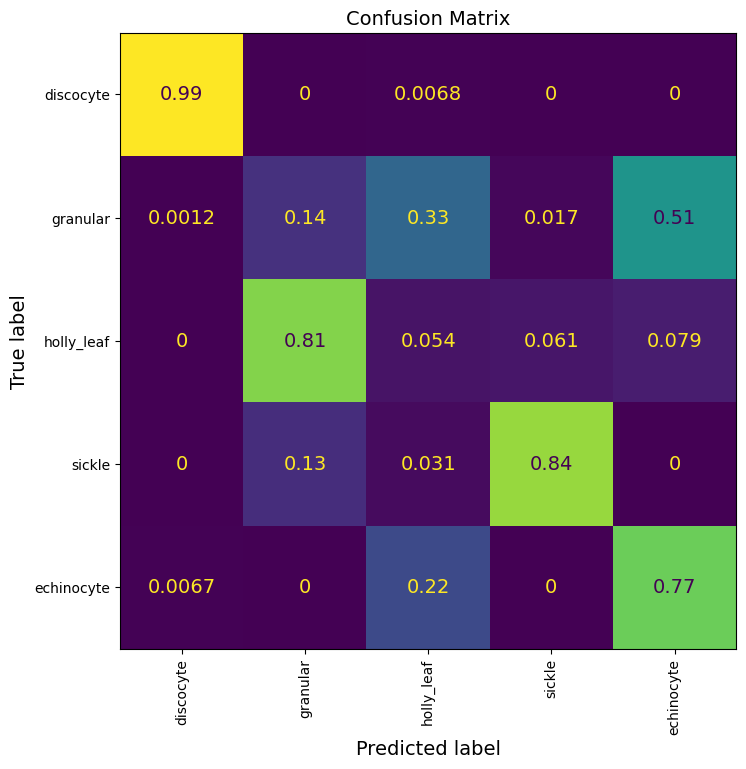

In [16]:
get_confusion_matrix(y_test, y_pred, class_names)